In [8]:
import pandas as pd
import numpy as np

data2019 = pd.read_csv("./FullData2019.csv")
data2016 = pd.read_csv("./FullData2016.csv")

In [37]:
def FCSStaus(val):
    if val <=21:
        return 1
    else:
        return 0
# create the binary food insecurity indicator
data2019['FCSStaus'] = data2019['FCS'].apply(FCSStaus)
data2016['FCSStaus'] = data2016['FCS'].apply(FCSStaus)
# imputation for NA, with mode  
individual = ['HouseType', 'RoofType', 'WaterSource',
       'DistDrinkingWater', 'ShareToilet', 'Income', 'Kind Income Ratio', 'Salt', 'SubjectivePoverty', 'RelLivStandard',
       'IncomeStab', 'LivStandChange','MaleRatio', 'AvgAge'] # ShareToilet and Salt are dummies 

for i in individual: 
    data2016[i].fillna(data2016[i].mode()[0],inplace=True)
    data2019[i].fillna(data2019[i].mode()[0],inplace=True)
wkd2016 = pd.get_dummies(data2016,columns=["ShareToilet","Salt"])
wkd2019 = pd.get_dummies(data2019,columns=["ShareToilet","Salt"])

In [38]:
# frequency encoding 
freq = ['HouseType', 'RoofType', 'WaterSource',
       'DistDrinkingWater', 'SubjectivePoverty', 'RelLivStandard',
       'IncomeStab', 'LivStandChange']
for i in freq: 
    freqf = data2016.groupby(i).size()/len(data2016)
    wkd2016[f"{i}_feq"] = wkd2016[i].apply(lambda x : freqf[x])
for j in freq: 
    freqf = data2019.groupby(j).size()/len(data2019)
    wkd2019[f"{j}_feq"] = wkd2019[j].apply(lambda x : freqf[x])

Time corss vaildation

In [39]:
time_splitted_data_1920 = { }
time_splitted_data_1617 = { }

for y in [2019, 2020]:
    for m in range(1,13):
        if wkd2019.query("year == @y and month == @m").shape[0] != 0: 
            time_splitted_data_1920[f"{y}_{m}"] = wkd2019.query("year == @y and month == @m").reset_index(drop = True)
        else: 
            continue 
for y in [2016, 2017]:
    for m in range(1,13):
        if wkd2016.query("year == @y and month == @m").shape[0] != 0: 
            time_splitted_data_1617[f"{y}_{m}"] = wkd2016.query("year == @y and month == @m").reset_index(drop = True)
        else: 
            continue               

In [32]:
np.savetxt("wkd2019cols.txt", np.array(wkd2019.columns.astype('str')).reshape(1,-1), delimiter=', ', fmt='%s')

In [40]:
s1 = set(wkd2016['County'])
s2 = set(wkd2019['County'])
len(s2 - s1)

23

### warm up
Predict the pre and post covid at 9,10,11 months, using 2016/17 data
response variable is binary

In [42]:
predictorList = ['mnts','urban','NL_District',
       'fatalities', 'temperature', 'temperature lag1',
       'temperature lag2', 'temperature lag3', 'temperature lag4',
       'precipitation', 'precipitation lag1', 'precipitation lag2',
       'precipitation lag3', 'precipitation lag4', 'NDVI', 
        'NDVI Anomaly',
       'HouseType_feq', 'RoofType_feq', 'WaterSource_feq',
       'DistDrinkingWater_feq', 'ShareToilet_Yes', 'Income', 'Kind Income Ratio', 'Salt_Yes', 
       'SubjectivePoverty_feq', 'RelLivStandard_feq',
       'IncomeStab_feq', 'LivStandChange_feq','MaleRatio', 'AvgAge' ]

In [43]:
binaryList = ['mnts','urban','ShareToilet_Yes','Salt_Yes']
freqList = [f"{j}_feq" for j in freq]
standardizationList = list(set(predictorList) - set(binaryList) - set(freqList))

In [44]:
from sklearn.model_selection import train_test_split

X_train = wkd2016[predictorList]
Y_train = wkd2016['FCSStaus']

X_test_pre = wkd2019.query("month >= 9 and month <= 11 and covid == 0").reset_index()[predictorList]
X_test_post = wkd2019.query("month >= 9 and month <= 11 and covid == 1").reset_index()[predictorList]

Y_test_pre = wkd2019.query("month >= 9 and month <= 11 and covid == 0").reset_index()['FCSStaus']
Y_test_post = wkd2019.query("month >= 9 and month <= 11 and covid == 1").reset_index()['FCSStaus']


In [45]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
std.fit(X_train[standardizationList])
x_train_standardized1 = pd.DataFrame(std.transform(X_train[standardizationList]),columns=standardizationList)
x_train_using = pd.concat([x_train_standardized1,X_train[binaryList], X_train[freqList]],axis=1)
# to prevent data leakage 
x_test_standardized1 = pd.DataFrame(std.transform(X_test_pre[standardizationList]),columns=standardizationList)
x_test_using_pre = pd.concat([x_test_standardized1, X_test_pre[binaryList],  X_test_pre[freqList]],axis=1)
x_test_standardized2 = pd.DataFrame(std.transform(X_test_post[standardizationList]),columns=standardizationList)
x_test_using_post = pd.concat([x_test_standardized2, X_test_post[binaryList],  X_test_post[freqList]],axis=1)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = x_train_using[standardizationList].corr()

# Plot heatmap
plt.figure(figsize=(20, 20))  # Set the size of the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Coefficient Heatmap')
plt.show()


In [46]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

smote = SMOTE(random_state=527)
X_smote, Y_smote = smote.fit_resample(x_train_using,Y_train)

adasyn = ADASYN(random_state=527)
X_ADA , Y_ADA = adasyn.fit_resample(x_train_using, Y_train)

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import shap
from sklearn.svm import SVC

#### Logistic

In [ ]:
LR_l1 = LogisticRegression(penalty='elasticnet',random_state=527,solver='saga',max_iter=1000)

grid = {"C":[10**i for i in range(-5,2,1)],"l1_ratio":np.arange(0,1.1,0.3)}
crossval = GridSearchCV(LR_l1,grid,cv=5,scoring="roc_auc")

crossval.fit(X_smote,Y_smote)
crossval.best_params_

In [76]:
LR_l1 = LogisticRegression(penalty='elasticnet',random_state=527,solver='saga',max_iter=1000,C=0.0001,l1_ratio=0.3)
# LR_l1 = LogisticRegression(max_iter=1000)
LR_l1.fit(X_smote,Y_smote)
# LR_fit = LR_l1.fit(x_train_using,Y_train)

y_LRpred_pre = LR_l1.predict(x_test_using_pre)
y_LRpred_post = LR_l1.predict(x_test_using_post)

report_pre = classification_report(Y_test_pre,y_LRpred_pre,output_dict=True)
report_post = classification_report(Y_test_post,y_LRpred_post,output_dict=True)
pd.DataFrame(report_pre).T

,precision,recall,f1-score,support
0,0.958897,0.924273,0.941267,1994.000000
1,0.101190,0.177083,0.128788,96.000000
accuracy,0.889952,0.889952,0.889952,0.889952
macro avg,0.530044,0.550678,0.535027,2090.000000
weighted avg,0.919500,0.889952,0.903947,2090.000000


In [72]:
pd.DataFrame(report_post).T

,precision,recall,f1-score,support
0,0.967423,0.944227,0.955685,3837.000000
1,0.213235,0.322222,0.256637,180.000000
accuracy,0.916355,0.916355,0.916355,0.916355
macro avg,0.590329,0.633225,0.606161,4017.000000
weighted avg,0.933628,0.916355,0.924361,4017.000000


In [77]:
explainer = shap.Explainer(LR_l1)
shap_values = explainer(X_smote)

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: LogisticRegression(C=0.0001, l1_ratio=0.3, max_iter=1000, penalty='elasticnet',
                   random_state=527, solver='saga')

In [209]:
y_LRprobab = LR_fit.predict_proba(x_test_using_pre)
y_LRprobab

array([[0.75073027, 0.24926973],
       [0.96675221, 0.03324779],
       [0.96372538, 0.03627462],
       ...,
       [0.99501927, 0.00498073],
       [0.99426128, 0.00573872],
       [0.99238463, 0.00761537]])

In [214]:
confusion_matrix(Y_test_pre,y_LRpred_pre,normalize='true')

array([[0.92427282, 0.07572718],
       [0.82291667, 0.17708333]])

In [215]:
confusion_matrix(Y_test_post,y_LRpred_post,normalize='true')

array([[0.94422726, 0.05577274],
       [0.67777778, 0.32222222]])

#### Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [49]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=500,n_jobs=-1,random_state=527,criterion = 'entropy', 
                            class_weight='balanced')

grid_rf = {"min_samples_leaf":[10,20,100],'max_features':[5,10]}

crossval_rf = GridSearchCV(RF,grid_rf,cv=5,scoring="roc_auc")

crossval_rf.fit(X_train,Y_train)
crossval_rf.best_params_

{'max_features': 10, 'min_samples_leaf': 100}

In [52]:
RF = RandomForestClassifier(n_estimators=1000,n_jobs=-1,random_state=527,criterion='entropy',
                            min_samples_leaf=100, max_features = 10, class_weight='balanced')

RF.fit(X_train[predictorList],Y_train)


y_RFpred_pre = RF.predict(x_test_using_pre[predictorList])
y_RFpred_post = RF.predict(x_test_using_post[predictorList])

y_RFpred_pre_proba = RF.predict_proba(x_test_using_pre[predictorList])
y_RFpred_post_proba = RF.predict_proba(x_test_using_post[predictorList])

report_pre = classification_report(Y_test_pre,y_RFpred_pre,output_dict=True)
report_post = classification_report(Y_test_post,y_RFpred_post,output_dict=True)
pd.DataFrame(report_pre).T, pd.DataFrame(report_post).T

(              precision    recall  f1-score      support
 0              0.964246  0.863864  0.911299  1998.000000
 1              0.105263  0.333333  0.160000    96.000000
 accuracy       0.839542  0.839542  0.839542     0.839542
 macro avg      0.534754  0.598599  0.535649  2094.000000
 weighted avg   0.924866  0.839542  0.876855  2094.000000,
               precision    recall  f1-score      support
 0              0.967489  0.868421  0.915282  3838.000000
 1              0.118674  0.377778  0.180611   180.000000
 accuracy       0.846441  0.846441  0.846441     0.846441
 macro avg      0.543081  0.623099  0.547947  4018.000000
 weighted avg   0.929464  0.846441  0.882370  4018.000000)

In [55]:
roc_auc_score(Y_test_pre, y_RFpred_pre_proba[:,1]), roc_auc_score(Y_test_post, y_RFpred_post_proba[:,1])

(0.6654753712045378, 0.7005724914596723)

In [56]:
f1_score(Y_test_pre,y_RFpred_pre)

0.16

In [16]:
confusion_matrix(Y_test_pre,y_RFpred_pre)

array([[ 569, 1425],
       [  14,   82]], dtype=int64)

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


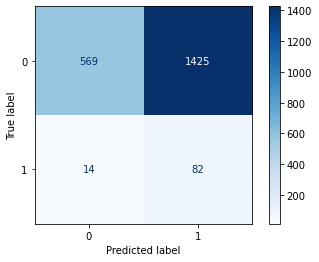

In [17]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(RF, x_test_using_pre, Y_test_pre, cmap=plt.cm.Blues)
plt.show()

Text(0, 0.5, 'Mean decrease in impurity')

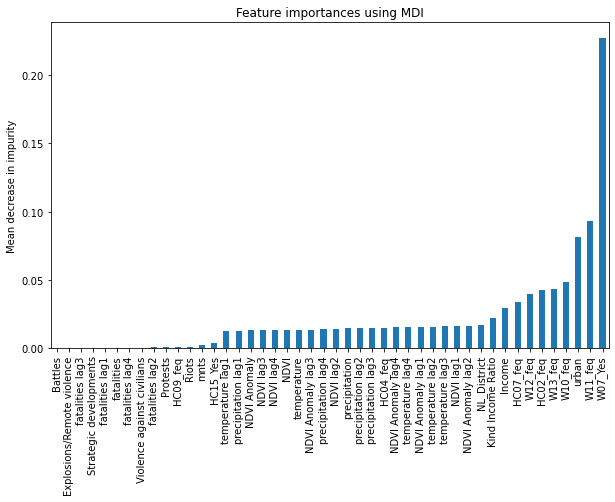

In [18]:
importances = RF.feature_importances_
forest_importances = pd.Series(importances, index=x_train_using.columns)

fig, ax = plt.subplots(figsize=(10, 6))
forest_importances.sort_values().plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")


In [22]:
X_present = X_smote.sample(frac=0.01)
explainer = shap.Explainer(RF.predict, X_present)
shap_values = explainer(X_present)

Permutation explainer: 291it [04:25,  1.05it/s]                         


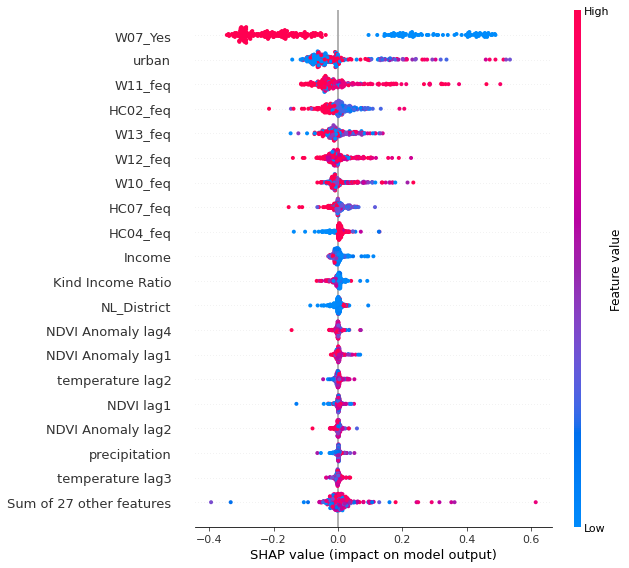

In [35]:
shap.plots.beeswarm(shap_values, max_display = 20)

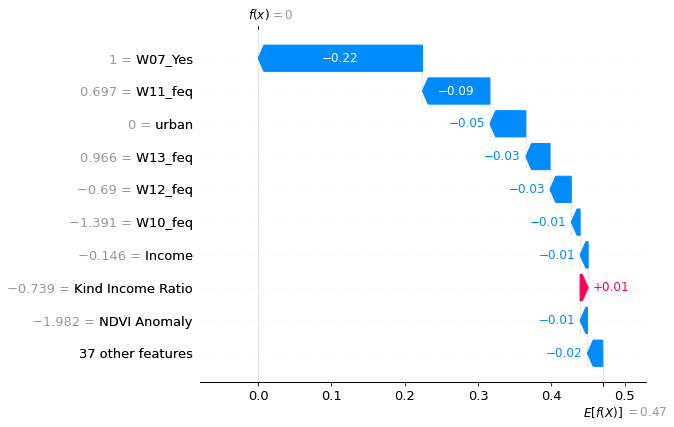

In [27]:
shap.plots.waterfall(shap_values[0])

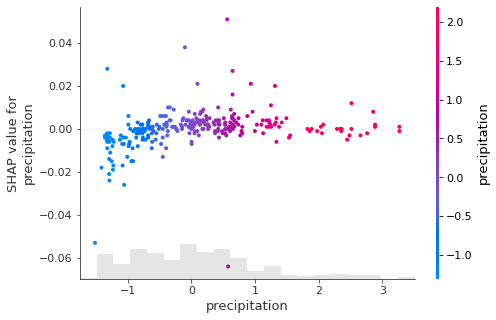

In [37]:
shap.plots.scatter(shap_values[:,"precipitation"], color=shap_values[:,"precipitation"])

In [49]:
X_present = X_smote.sample(frac=0.01)
explainer = shap.TreeExplainer(RF, feature_perturbation="tree_path_dependent", model_output='raw')
shap_values = explainer(X_present)

In [56]:
shap_values[0,0,1]

.values =
0.005150289066706848

.base_values =
0.49995366981978895

.data =
1.6953781040371856

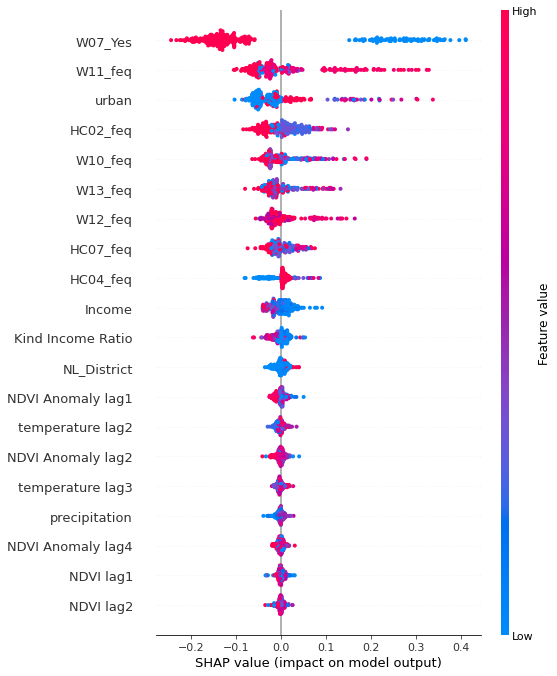

In [58]:
shap.summary_plot(shap_values[:,:,1], max_display = 20)

#### XGBoost

In [62]:
import xgboost as xgb # use xgb.cv 
from xgboost.sklearn import XGBClassifier
from sklearn import metrics 
import matplotlib.pyplot as plt

def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50,XTestPre = X_test_pre,
             XTestPost =X_test_post, YTestPre = Y_test_pre,YTestPost = Y_test_post ):
    """Fit the XGBoost automatically and return the needed matrics and importance figure 

    Args:
        alg (_type_): xgboost model
        dtrain (_type_): dataframe of training data 
        predictors (_type_): predictor list 
        useTrainCV (bool, optional): if use the CV to find the best n_estimator. Defaults to True.
        cv_folds (int, optional): CV folds. Defaults to 5.
        early_stopping_rounds (int, optional): for iteration. Defaults to 50.
        XTestPre (_type_, optional): test before covid. Defaults to X_test_pre.
        XTestPost (_type_, optional): test after covid. Defaults to X_test_post.
        YTestPre (_type_, optional): Y test before covid. Defaults to Y_test_pre.
        YTestPost (_type_, optional): Y test after covid. Defaults to Y_test_post.
    """
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain["FCSStaus"].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['FCSStaus'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    dtest_predprob_pre = alg.predict_proba(XTestPre)[:,1]
    dtest_predprob_post = alg.predict_proba(XTestPost)[:,1]
    dtest_predictions_pre = alg.predict(XTestPre)
    dtest_predictions_post = alg.predict(XTestPost)
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['FCSStaus'].values, dtrain_predictions))
    print( "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['FCSStaus'], dtrain_predprob))
    print( "AUC Score (Test Pre): %f" % metrics.roc_auc_score(YTestPre, dtest_predprob_pre))
    print( "AUC Score (Test Post): %f" % metrics.roc_auc_score(YTestPost, dtest_predprob_post))
    print( "F1 Macro Score (Test Pre): %f" % metrics.f1_score(YTestPre, dtest_predictions_pre, average="macro"))
    print( "F1 Macro Score (Test Post): %f" % metrics.f1_score(YTestPost, dtest_predictions_post, average="macro"))
    print( "F1 Weighted Score (Test Pre): %f" % metrics.f1_score(YTestPre, dtest_predictions_pre, average="weighted"))
    print( "F1 Weighted Score (Test Post): %f" % metrics.f1_score(YTestPost, dtest_predictions_post, average="weighted"))
    print( "Accuracy (Test Pre): %f" % metrics.accuracy_score(YTestPre, dtest_predictions_pre))
    print( "Accuracy (Test Post): %f" % metrics.accuracy_score(YTestPost, dtest_predictions_post))
          
    importances = alg.feature_importances_
    feature_names = np.array(predictors)  
    # Plot feature importances
    indices = np.argsort(importances)[::-1]
    sorted_importances = importances[indices]
    sorted_feature_names = feature_names[indices]

    # Plot feature importances
    plt.bar(range(len(sorted_importances)), sorted_importances)
    plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation='vertical')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importances')
    plt.show()


Model Report
Accuracy : 0.9866
AUC Score (Train): 0.999162
AUC Score (Test Pre): 0.533567
AUC Score (Test Post): 0.563657
F1 Macro Score (Test Pre): 0.043916
F1 Macro Score (Test Post): 0.042888
F1 Weighted Score (Test Pre): 0.004034
F1 Weighted Score (Test Post): 0.003844
Accuracy (Test Pre): 0.045933
Accuracy (Test Post): 0.044810


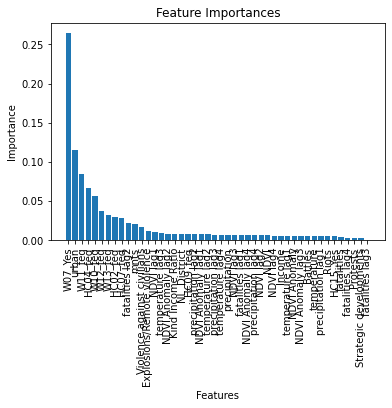

In [63]:
DataTrain = pd.concat([X_smote,Y_smote],axis=1)
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, DataTrain, predictorList)

In [14]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(X_smote,Y_smote)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 9, 'min_child_weight': 3}, 0.9763483087285032)

In [18]:
param_test2 = {
 'max_depth':[16,18,20,22]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)
gsearch2.fit(X_smote,Y_smote)
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 16}, 0.9786582030718769)

In [21]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=16,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)
gsearch3.fit(X_smote,Y_smote)
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.0}, 0.9786582030718769)


Model Report
Accuracy : 0.9978
AUC Score (Train): 0.999989
AUC Score (Test Pre): 0.575599
AUC Score (Test Post): 0.601370
F1 Macro Score (Test Pre): 0.043916
F1 Macro Score (Test Post): 0.042888
F1 Weighted Score (Test Pre): 0.004034
F1 Weighted Score (Test Post): 0.003844
Accuracy (Test Pre): 0.045933
Accuracy (Test Post): 0.044810


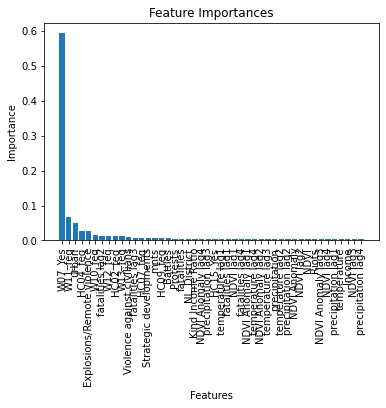

In [49]:
xgb2 = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=16,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
modelfit(xgb2, DataTrain, predictorList)

In [51]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=16,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=5)
gsearch4.fit(X_smote,Y_smote)
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.6, 'subsample': 0.9}, 0.9786837196162356)

In [53]:
param_test5 = {
 'subsample':[i/10.0 for i in range(9,11)],
 'colsample_bytree':[i/10.0 for i in range(5,8)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=16,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4, cv=5)
gsearch5.fit(X_smote,Y_smote)
gsearch5.best_params_, gsearch5.best_score_

({'colsample_bytree': 0.5, 'subsample': 0.9}, 0.9794594257410438)

In [55]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=16,
 min_child_weight=3, gamma=0, subsample=0.9, colsample_bytree=0.5,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4, cv=5)
gsearch6.fit(X_smote,Y_smote)
gsearch6.best_params_, gsearch6.best_score_

({'reg_alpha': 1e-05}, 0.9797563883737379)


Model Report
Accuracy : 0.9949
AUC Score (Train): 0.999966
AUC Score (Test Pre): 0.574878
AUC Score (Test Post): 0.653258
F1 Macro Score (Test Pre): 0.043916
F1 Macro Score (Test Post): 0.042888
F1 Weighted Score (Test Pre): 0.004034
F1 Weighted Score (Test Post): 0.003844
Accuracy (Test Pre): 0.045933
Accuracy (Test Post): 0.044810


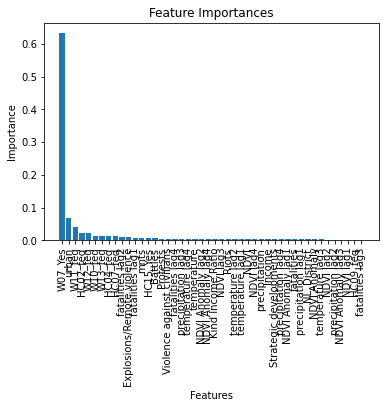

In [57]:
xgb3 = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=16,
 min_child_weight=3, gamma=0, subsample=0.9, colsample_bytree=0.5,reg_alpha = 1e-5, 
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
modelfit(xgb3, DataTrain, predictorList)


Model Report
Accuracy : 0.9881
AUC Score (Train): 0.999573
AUC Score (Test Pre): 0.499297
AUC Score (Test Post): 0.439590
F1 Macro Score (Test Pre): 0.043916
F1 Macro Score (Test Post): 0.042888
F1 Weighted Score (Test Pre): 0.004034
F1 Weighted Score (Test Post): 0.003844
Accuracy (Test Pre): 0.045933
Accuracy (Test Post): 0.044810


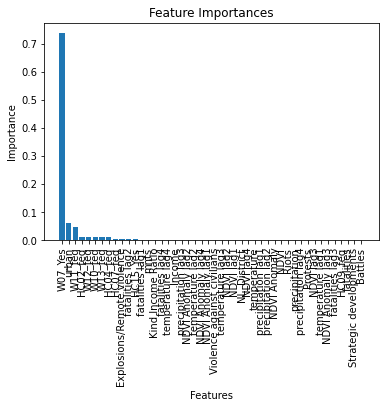

In [58]:
xgb4 = XGBClassifier( learning_rate =0.01, n_estimators=5000, max_depth=16,
 min_child_weight=3, gamma=0, subsample=0.9, colsample_bytree=0.5,reg_alpha = 1e-5, 
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
modelfit(xgb4, DataTrain, predictorList)

we can conclude that, there are strong over-fitting issue, the distribution of 16/17 data and 19/20 data are dirrerent! The finer the model, the wrose the f1 and prediction 

#### SVM

In [ ]:
SVMClf = SVC()
grid_svm = {'C':[0.01, 0.1, 1, 10], 'kernel':['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']}
cross_svm = GridSearchCV(SVMClf,grid_svm,cv=5,scoring="f1_macro")
cross_svm.fit(X_train, Y_train)

In [ ]:
cross_svm.best_params_

### Case 2: time series naive model without feature engineering

In [142]:
# predictorList = ['mnts','urban','NL_District','Strategic developments', 'Battles', 'Riots',
#        'Explosions/Remote violence', 'Violence against civilians', 'Protests',
#        'fatalities', 'fatalities lag1', 'fatalities lag2', 'fatalities lag3',
#        'fatalities lag4', 'temperature', 'temperature lag1',
#        'temperature lag2', 'temperature lag3', 'temperature lag4',
#        'precipitation', 'precipitation lag1', 'precipitation lag2',
#        'precipitation lag3', 'precipitation lag4', 'NDVI', 
#        'NDVI lag1', 'NDVI lag2', 'NDVI lag3', 'NDVI lag4', 'NDVI Anomaly',
#        'NDVI Anomaly lag1', 'NDVI Anomaly lag2', 'NDVI Anomaly lag3',
#        'NDVI Anomaly lag4', 'Rainfall (mm)', 'Average (mm)', 'Rainfall lag1', 'Rainfall lag2' ,
#        'Rainfall lag3' ,'Rainfall lag4', '1 Month Anomaly (%)', '3 Months Anomaly (%)', 'Income', 
#        'Kind Income Ratio','MaleRatio', 'AvgAge',
#        'SelfArg', 'SelfHerd', 'OwnNow_ArgLand', 'valueNow_ArgLand',
#        'Own1yrAgo_ArgLand', 'ValueAgo_ArgLand', 'OwnNow_TV', 'valueNow_TV',
#        'Own1yrAgo_TV', 'ValueAgo_TV', 'OwnNow_FixPhone', 'valueNow_FixPhone',
#        'Own1yrAgo_FixPhone', 'ValueAgo_FixPhone', 'OwnNow_MobilePhone',
#        'valueNow_MobilePhone', 'Own1yrAgo_MobilePhone', 'ValueAgo_MobilePhone',
#        'OwnNow_Refrigerator', 'valueNow_Refrigerator',
#        'Own1yrAgo_Refrigerator', 'ValueAgo_Refrigerator', 'OwnNow_Furniture',
#        'valueNow_Furniture', 'Own1yrAgo_Furniture', 'ValueAgo_Furniture',
#        'OwnNow_Cooker', 'valueNow_Cooker', 'Own1yrAgo_Cooker',
#        'ValueAgo_Cooker', 'OwnNow_Livestock', 'valueNow_Livestock',
#        'Own1yrAgo_Livestock', 'ValueAgo_Livestock', 'ShareToilet_Yes', 'Salt_Yes',
#        'HouseType_feq', 'RoofType_feq', 'WaterSource_feq',
#        'DistDrinkingWater_feq', 'SubjectivePoverty_feq', 'RelLivStandard_feq',
#        'IncomeStab_feq', 'LivStandChange_feq','valueNowTotal']

predictorList = ['urban','NL_District',
       'fatalities', 'temperature', 'NDVI', 'NDVI Anomaly', 'Rainfall (mm)', 'Average (mm)', 
       '1 Month Anomaly (%)', '3 Months Anomaly (%)', 'Income', 
       'Kind Income Ratio','MaleRatio', 'AvgAge',
       'SelfArg', 'SelfHerd', 'OwnNow_ArgLand', 'OwnNow_TV', 
        'OwnNow_FixPhone','OwnNow_MobilePhone', 
       'OwnNow_Refrigerator',
       'OwnNow_Cooker',  
       'ShareToilet_Yes', 'Salt_Yes','HouseType_feq', 'RoofType_feq', 'WaterSource_feq',
       'DistDrinkingWater_feq', 'SubjectivePoverty_feq', 'RelLivStandard_feq',
       'IncomeStab_feq', 'LivStandChange_feq','valueNowTotal']

# binaryList = ['mnts','urban','Salt_Yes','ShareToilet_Yes','SelfArg', 'SelfHerd', 'OwnNow_ArgLand',
#        'Own1yrAgo_ArgLand', 'OwnNow_TV',
#        'Own1yrAgo_TV', 'OwnNow_FixPhone',
#        'Own1yrAgo_FixPhone', 'OwnNow_MobilePhone', 'Own1yrAgo_MobilePhone',
#        'OwnNow_Refrigerator',
#        'Own1yrAgo_Refrigerator', 'OwnNow_Furniture', 'Own1yrAgo_Furniture',
#        'OwnNow_Cooker', 'Own1yrAgo_Cooker', 'OwnNow_Livestock',
#        'Own1yrAgo_Livestock']
binaryList = ['urban','Salt_Yes','ShareToilet_Yes','SelfArg', 'SelfHerd', 'OwnNow_ArgLand',
       'OwnNow_TV','OwnNow_FixPhone','OwnNow_MobilePhone',
       'OwnNow_Refrigerator',
       'OwnNow_Cooker']
freqList = [f"{i}_feq" for i in freq]
standardizationList = list(set(predictorList) - set(binaryList) - set(freqList))

In [135]:
wkd2019.isna().sum(axis=0).sum()

0

In [191]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import shap
from sklearn.decomposition import PCA
from sklearn.svm import SVC

def StandardizerTrainTest(X_train, X_test, standardizationList, binaryList):
    """Standardization and prevent data leakage

    Args:
        X_train (pd.dataframe): training data
        X_test (pd.dataframe): testing data
        standardizationList (list): continuous variables needed to be standardized 
        binaryList (list): binary variables  

    Returns:
        pd.DataFrame: train, test 
    """
    std = StandardScaler()
    std.fit(X_train[standardizationList])
    x_train_standardized1 = pd.DataFrame(std.transform(X_train[standardizationList]),columns=standardizationList)
    x_train_using = pd.concat([x_train_standardized1,X_train[binaryList]],axis=1)
    # to prevent data leakage 
    x_test_standardized1 = pd.DataFrame(std.transform(X_test[standardizationList]),columns=standardizationList)
    x_test_using = pd.concat([x_test_standardized1,X_test[binaryList]],axis=1)
    return x_train_using, x_test_using

def resampling(X_train, Y_train): 
    """generate the resampling data

    Args:
        X_train (dataframe): X_train
        Y_train (dataframe): X_train

    Returns:
        dataframe: X_smote, Y_smote, X_ADA, Y_ADA
    """
    smote = SMOTE(random_state=527)
    X_smote, Y_smote = smote.fit_resample(X_train,Y_train)
    adasyn = ADASYN(random_state=527)
    X_ADA , Y_ADA = adasyn.fit_resample(X_train, Y_train)
    
    return X_smote, Y_smote, X_ADA, Y_ADA


In [143]:
date19List = [i for i in time_splitted_data_1920.keys()]
data19List = [i for i in time_splitted_data_1920.values()]

# here we generate the "time series" train and test data, we use the first 4 months in 19/20 data as the first set
# of training data, and then add one month in each round, the test data is the next month of the last train data 

# trainDataStart = pd.DataFrame(columns=time_splitted_data_1920["2020_2"].columns)
trainDataStart = data19List[0].copy()

for i in range(1, 4):
    interTrainData = data19List[i].copy()
    trainDataStart = pd.concat([trainDataStart, interTrainData], axis=0)
    
# trainDataStart = pd.concat([trainDataStart,wkd2016], axis=0) # append 2016 data 

trainData = {"train_3":trainDataStart.reset_index(drop = True)}
testData = {"test_3":data19List[4].reset_index(drop = True)}

for i in range(4, len(time_splitted_data_1920.keys()) - 1):
    interTrainData = pd.concat([trainData[f"train_{i - 1}"], data19List[i].copy()], axis=0)
    interTestData = data19List[i + 1].copy()
    trainData[f"train_{i}"] = interTrainData.reset_index(drop = True)
    testData[f"test_{i}"] = interTestData.reset_index(drop = True)
# standardize and resample 
StdTrain = {}
StdTest = {}
train19List = [i for i in trainData.values()]
test19List = [i for i in testData.values()]

for train, test, name1, name2 in zip(train19List, test19List,  trainData.keys(), testData.keys()):
    standardizedTrain, standardizedTest = StandardizerTrainTest(train[predictorList], test[predictorList], standardizationList, binaryList)
    standardizedTrain_withY = pd.concat([standardizedTrain,train[['FCSStaus','FCS']]], axis=1)
    standardizedTest_withY = pd.concat([standardizedTest,test[['FCSStaus','FCS']]], axis=1)
    StdTrain[f"{name1}"] = standardizedTrain_withY
    StdTest[f"{name2}"] = standardizedTest_withY
    
# pca = PCA()
# pcatet = PCA()
# pca.fit(StdTrain["train_9"][predictorList])
# pcadata = pca.fit_transform(StdTrain["train_9"][predictorList])
# usingdata = pd.DataFrame(pcadata[:,0:20],  columns=[f'PC{i}' for i in range(1,21)])
# # pca.explained_variance_ratio_[0:20].sum()

# pcatet.fit(StdTest["test_9"][predictorList])
# pcatet.explained_variance_ratio_[0:20].sum()
# pcadata2 = pcatet.fit_transform(StdTest["test_9"][predictorList])
# usingdata2 = pd.DataFrame(pcadata2[:,0:20], columns=[f'PC{i}' for i in range(1,21)])

# X_smote, Y_smote, X_ADA, Y_ADA = resampling(usingdata, StdTrain["train_9"]['FCSStaus'])
# X_smoteT, Y_smoteT, X_ADAT, Y_ADAT = resampling(usingdata2, StdTest["test_9"]['FCSStaus'])

In [144]:
SMOTE_Train = {}
ADASYN_Train = {}

for train, name1 in zip(StdTrain.values(),  trainData.keys()):
    X_smote, Y_smote, X_ADA, Y_ADA = resampling(train[predictorList], train['FCSStaus'])
    SMOTE_Train[f"{name1}"] = pd.concat([X_smote, Y_smote], axis=1)
    ADASYN_Train[f"{name1}"] = pd.concat([X_ADA, Y_ADA], axis=1)

In [118]:
SMOTE_Train['train_4']['FCSStaus'].value_counts()

1    3611
0    3611
Name: FCSStaus, dtype: int64

#### Logistic

In [74]:
LR_l1 = LogisticRegression(penalty='elasticnet',random_state=527,solver='saga',max_iter=1000)

grid = {"C":[10**i for i in range(-5,2,1)],"l1_ratio":np.arange(0,1.1,0.2)}
crossval = GridSearchCV(LR_l1,grid,cv=5,scoring="roc_auc")

crossval.fit(SMOTE_Train['train_3'][predictorList],SMOTE_Train['train_3']['FCSStaus'])
crossval.best_params_

{'C': 0.1, 'l1_ratio': 1.0}

In [75]:
LR_l1 = LogisticRegression(penalty='elasticnet',random_state=527,solver='saga',max_iter=1000,C=0.1,l1_ratio=1)
# LR_l1 = LogisticRegression(penalty='elasticnet',random_state=527,solver='saga',max_iter=1000,
                        #    **crossval.best_params_)
# LR_l1.get_params()
LR_l1 = LogisticRegression(max_iter=1000)
LR_l1.fit(SMOTE_Train['train_3'][predictorList],SMOTE_Train['train_3']['FCSStaus'])
# LR_fit = LR_l1.fit(x_train_using,Y_train)

y_LRpred_test = LR_l1.predict(StdTest['test_3'][predictorList])

report_test = classification_report(StdTest['test_3']['FCSStaus'],y_LRpred_test,output_dict=True)
pd.DataFrame(report_test).T

,precision,recall,f1-score,support
0,0.980233,0.513086,0.673592,1643.000000
1,0.041916,0.673077,0.078918,52.000000
accuracy,0.517994,0.517994,0.517994,0.517994
macro avg,0.511074,0.593081,0.376255,1695.000000
weighted avg,0.951446,0.517994,0.655348,1695.000000


In [76]:
y_LRpred_train = LR_l1.predict(StdTrain['train_3'][predictorList])
report_train = classification_report(StdTrain['train_3']['FCSStaus'],y_LRpred_train,output_dict=True)
pd.DataFrame(report_train).T

,precision,recall,f1-score,support
0,0.975585,0.757504,0.852823,2532.000000
1,0.101025,0.589744,0.172500,117.000000
accuracy,0.750094,0.750094,0.750094,0.750094
macro avg,0.538305,0.673624,0.512662,2649.000000
weighted avg,0.936958,0.750094,0.822775,2649.000000


In [54]:
precision_score(StdTest['test_3']['FCSStaus'],y_LRpred_test)

0.04488778054862843

In [81]:
confusion_matrix(StdTest['test_3']['FCSStaus'],y_LRpred_test,normalize='true')

array([[0.008521  , 0.991479  ],
       [0.01923077, 0.98076923]])

#### Random Forest

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

In [145]:
from sklearn.ensemble import RandomForestClassifier

X_train = SMOTE_Train['train_9'][predictorList]
Y_train = SMOTE_Train['train_9']['FCSStaus']
# X_train = ADASYN_Train['train_9'][predictorList]
# Y_train = ADASYN_Train['train_9']['FCSStaus']
# X_train = StdTrain['train_9'][predictorList]
# Y_train = StdTrain['train_9']['FCSStaus']
# X_train = X_smote
# Y_train = Y_smote
X_test = StdTest['test_9'][predictorList]
Y_test = StdTest['test_9']['FCSStaus']
# Y_test = StdTest['test_9']['FCS']
# X_test = X_smoteT
# Y_test = Y_smoteT


RF = RandomForestClassifier(n_estimators=1000,n_jobs=-1,random_state=527)

grid_rf = {"min_samples_leaf":[5,10,20],'max_depth':[5, 10, 15]}

crossval_rf = GridSearchCV(RF,grid_rf,cv=5,scoring="roc_auc")

crossval_rf.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=1000, n_jobs=-1,
                                              random_state=527),
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_leaf': [5, 10, 20]},
             scoring='roc_auc')

In [146]:
crossval_rf.best_params_

{'max_depth': 15, 'min_samples_leaf': 5}

In [147]:
RF = RandomForestClassifier(n_estimators=1000,n_jobs=-1,random_state=527, **crossval_rf.best_params_)

RF.fit(X_train, Y_train)

y_RFpred_test = RF.predict(X_test)
# y_RF_reg = []

# for i in y_RFpred_test:
#     if i <= 35:
#         y_RF_reg.append(1)
#     else:
#         y_RF_reg.append(0)
        
# y_RF_reg
report_pre = classification_report(Y_test, y_RFpred_test, output_dict=True)
# report_pre = classification_report(Y_test, np.array(y_RF_reg).reshape((-1,1)), output_dict=True)
pd.DataFrame(report_pre).T

,precision,recall,f1-score,support
0,0.808777,0.903678,0.853598,571.00000
1,0.521739,0.329670,0.404040,182.00000
accuracy,0.764940,0.764940,0.764940,0.76494
macro avg,0.665258,0.616674,0.628819,753.00000
weighted avg,0.739400,0.764940,0.744940,753.00000


In [148]:
y_RFpred_train = RF.predict(X_train)
report_train = classification_report(Y_train,y_RFpred_train,output_dict=True)
pd.DataFrame(report_train).T

,precision,recall,f1-score,support
0,0.933606,0.967804,0.950398,10374.000000
1,0.966580,0.931174,0.948547,10374.000000
accuracy,0.949489,0.949489,0.949489,0.949489
macro avg,0.950093,0.949489,0.949472,20748.000000
weighted avg,0.950093,0.949489,0.949472,20748.000000


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


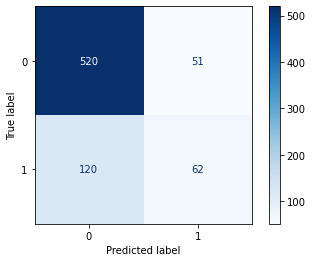

In [132]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
# plot_confusion_matrix(RF, StdTest['test_9'][predictorList], StdTest['test_9']['FCSStaus'], cmap=plt.cm.Blues)
plot_confusion_matrix(RF, X_test, Y_test, cmap=plt.cm.Blues)
plt.show()

Text(0, 0.5, 'Mean decrease in impurity')

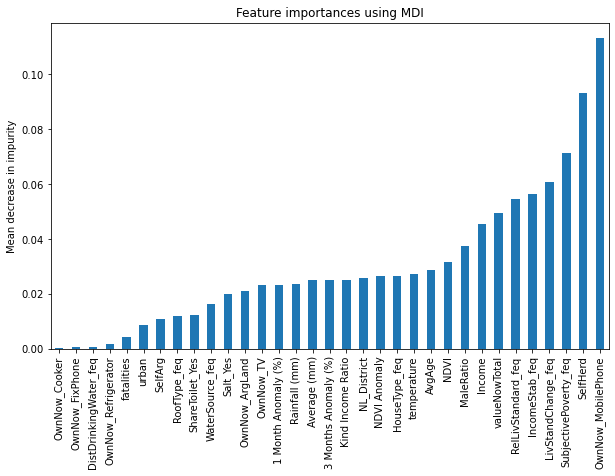

In [149]:
importances = RF.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots(figsize=(10, 6))
forest_importances.sort_values().plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")


In [151]:
X_present = X_train.sample(frac=0.001)
explainer = shap.Explainer(RF.predict, X_present)
shap_values = explainer(X_present)

Permutation explainer: 22it [00:27,  1.86s/it]                        


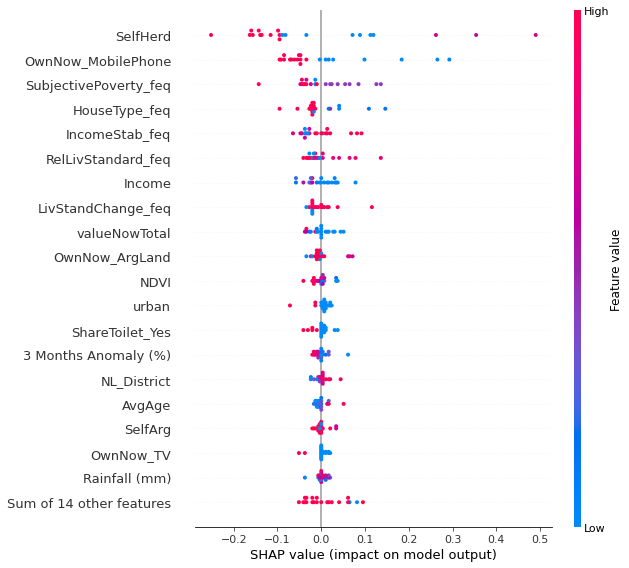

In [152]:
shap.plots.beeswarm(shap_values, max_display = 20)

In [35]:
X_present = X_train.sample(frac=0.01)
explainer = shap.TreeExplainer(RF, feature_perturbation="tree_path_dependent", model_output='raw')
shap_values = explainer(X_present)

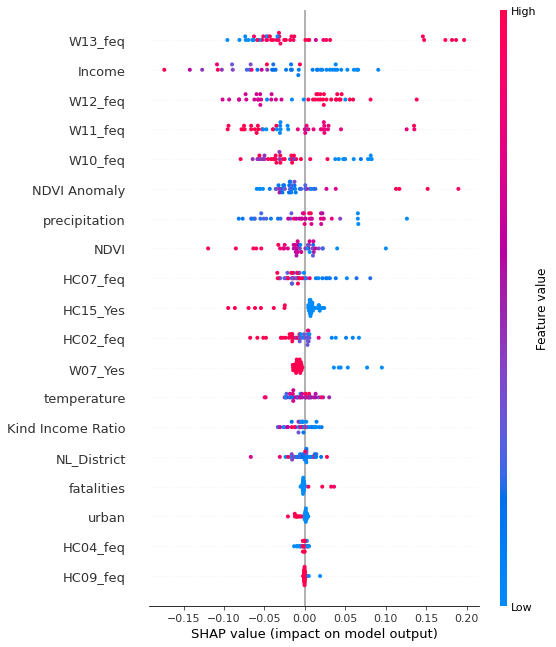

In [36]:
shap.summary_plot(shap_values[:,:,1], max_display = 20)

#### XGBoost

In [155]:
import xgboost as xgb # use xgb.cv 
from xgboost.sklearn import XGBClassifier
from sklearn import metrics 
import matplotlib.pyplot as plt

def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50,X_test = X_test,
             Y_test = Y_test):
    """Fit the XGBoost automatically and return the needed matrics and importance figure 

    Args:
        alg (_type_): xgboost model
        dtrain (_type_): dataframe of training data 
        predictors (_type_): predictor list 
        useTrainCV (bool, optional): if use the CV to find the best n_estimator. Defaults to True.
        cv_folds (int, optional): CV folds. Defaults to 5.
        early_stopping_rounds (int, optional): for iteration. Defaults to 50.
        X_test (_type_, optional): test before covid. Defaults to X_test.
        Y_test (_type_, optional): Y test before covid. Defaults to X_test.
    """
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain["FCSStaus"].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['FCSStaus'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    dtest_predprob_pre = alg.predict_proba(X_test)[:,1]
    dtest_predictions_pre = alg.predict(X_test)
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['FCSStaus'].values, dtrain_predictions))
    print( "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['FCSStaus'], dtrain_predprob))
    print( "AUC Score (Test): %f" % metrics.roc_auc_score(Y_test, dtest_predprob_pre))
    print( "F1 Macro Score (Test): %f" % metrics.f1_score(Y_test, dtest_predictions_pre, average="macro"))
    print( "F1 Weighted Score (Test): %f" % metrics.f1_score(Y_test, dtest_predictions_pre, average="weighted"))
    print( "Accuracy (Test): %f" % metrics.accuracy_score(Y_test, dtest_predictions_pre))
          
    importances = alg.feature_importances_
    feature_names = np.array(predictors)  
    # Plot feature importances
    indices = np.argsort(importances)[::-1]
    sorted_importances = importances[indices]
    sorted_feature_names = feature_names[indices]

    # Plot feature importances
    plt.bar(range(len(sorted_importances)), sorted_importances)
    plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation='vertical')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importances')
    plt.show()
    
    return alg, dtest_predprob_pre, dtest_predictions_pre


Model Report
Accuracy : 0.8884
AUC Score (Train): 0.919857
AUC Score (Test): 0.762803
F1 Macro Score (Test): 0.583217
F1 Weighted Score (Test): 0.728473
Accuracy (Test): 0.772908


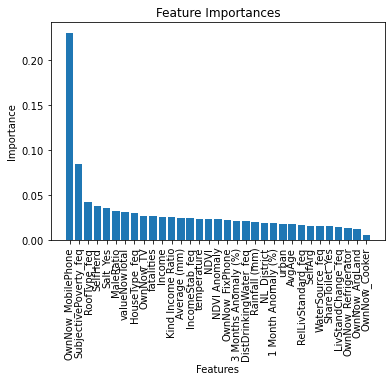

In [174]:
# X_train = SMOTE_Train['train_9'][predictorList]
# Y_train = SMOTE_Train['train_9']['FCSStaus']
# X_train = ADASYN_Train['train_9'][predictorList]
# Y_train = ADASYN_Train['train_9']['FCSStaus']
X_train = StdTrain['train_9'][predictorList]
Y_train = StdTrain['train_9']['FCSStaus']
# X_train = X_smote
# Y_train = Y_smote
X_test = StdTest['test_9'][predictorList]
Y_test = StdTest['test_9']['FCSStaus']
# Y_test = StdTest['test_9']['FCS']
# X_test = X_smoteT
# Y_test = Y_smoteT

DataTrain = pd.concat([X_train,Y_train],axis=1)
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb_estimator, test_pred_prob, test_pred_class = modelfit(xgb1, DataTrain, predictorList)

In [175]:
report_train = classification_report(Y_test,test_pred_class,output_dict=True)
pd.DataFrame(report_train).T

,precision,recall,f1-score,support
0,0.789855,0.954466,0.864393,571.000000
1,0.587302,0.203297,0.302041,182.000000
accuracy,0.772908,0.772908,0.772908,0.772908
macro avg,0.688578,0.578881,0.583217,753.000000
weighted avg,0.740898,0.772908,0.728473,753.000000


In [177]:
# param_test1 = {
#  'max_depth':range(3,10,2),
#  'min_child_weight':range(1,6,2)
# }
param_test1 = {
 'max_depth':range(1,4,1),
 'min_child_weight':range(5,10,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(X_train,Y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 2, 'min_child_weight': 7}, 0.7692304974094497)


Model Report
Accuracy : 0.8657
AUC Score (Train): 0.862868
AUC Score (Test): 0.753902
F1 Macro Score (Test): 0.603042
F1 Weighted Score (Test): 0.740299
Accuracy (Test): 0.780876


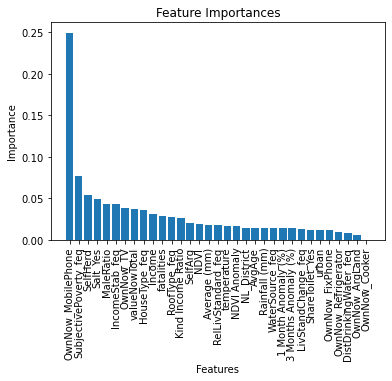

In [178]:
DataTrain = pd.concat([X_train,Y_train],axis=1)
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=2,
 min_child_weight=7,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb_estimator, test_pred_prob, test_pred_class = modelfit(xgb1, DataTrain, predictorList)

In [179]:
xgb_estimator.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=516, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)>

In [180]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=516, max_depth=2,
 min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)
gsearch3.fit(X_train,Y_train)
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.2}, 0.746460079455921)


Model Report
Accuracy : 0.8653
AUC Score (Train): 0.861393
AUC Score (Test): 0.755923
F1 Macro Score (Test): 0.603042
F1 Weighted Score (Test): 0.740299
Accuracy (Test): 0.780876


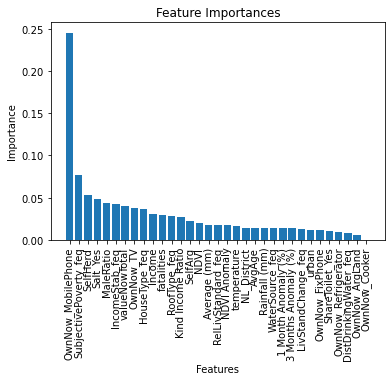

In [181]:
xgb2 = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=2,
 min_child_weight=7, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
xgb_estimator, test_pred_prob, test_pred_class = modelfit(xgb2, DataTrain, predictorList)

In [182]:
report_train = classification_report(Y_test,test_pred_class,output_dict=True)
pd.DataFrame(report_train).T

,precision,recall,f1-score,support
0,0.795918,0.956217,0.868735,571.000000
1,0.626866,0.230769,0.337349,182.000000
accuracy,0.780876,0.780876,0.780876,0.780876
macro avg,0.711392,0.593493,0.603042,753.000000
weighted avg,0.755058,0.780876,0.740299,753.000000


In [183]:
xgb_estimator.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=499, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)>

In [184]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=499, max_depth=2,
 min_child_weight=7, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=5)
gsearch4.fit(X_train,Y_train)
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.7, 'subsample': 0.6}, 0.7494785606697063)

In [ ]:
param_test5 = {
 'subsample':[i/10.0 for i in range(9,11)],
 'colsample_bytree':[i/10.0 for i in range(5,8)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=16,
 min_child_weight=3, gamma=0, subsample=0.9, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4, cv=5)
gsearch5.fit(X_train,Y_train)
gsearch5.best_params_, gsearch5.best_score_

({'colsample_bytree': 0.5, 'subsample': 0.9}, 0.9794594257410438)

In [185]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=500, max_depth=2,
 min_child_weight=7, gamma=0.2, subsample=0.6, colsample_bytree=0.7,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4, cv=5)
gsearch6.fit(X_train,Y_train)
gsearch6.best_params_, gsearch6.best_score_

({'reg_alpha': 100}, 0.7600144236975168)


Model Report
Accuracy : 0.8352
AUC Score (Train): 0.780648
AUC Score (Test): 0.727132
F1 Macro Score (Test): 0.486853
F1 Weighted Score (Test): 0.681535
Accuracy (Test): 0.763612


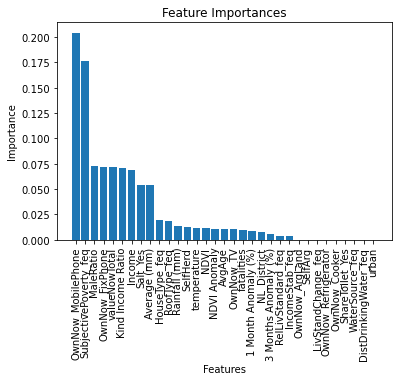

In [186]:
xgb3 = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=2,
 min_child_weight=7, gamma=0.2, subsample=0.6, colsample_bytree=0.7,reg_alpha = 100, 
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
xgb_estimator, test_pred_prob, test_pred_class = modelfit(xgb3, DataTrain, predictorList)

In [187]:
report_train = classification_report(Y_test,test_pred_class,output_dict=True)
pd.DataFrame(report_train).T

,precision,recall,f1-score,support
0,0.767347,0.987741,0.863706,571.000000
1,0.611111,0.060440,0.110000,182.000000
accuracy,0.763612,0.763612,0.763612,0.763612
macro avg,0.689229,0.524090,0.486853,753.000000
weighted avg,0.729585,0.763612,0.681535,753.000000



Model Report
Accuracy : 0.8346
AUC Score (Train): 0.779718
AUC Score (Test): 0.724649
F1 Macro Score (Test): 0.477312
F1 Weighted Score (Test): 0.676690
Accuracy (Test): 0.762284


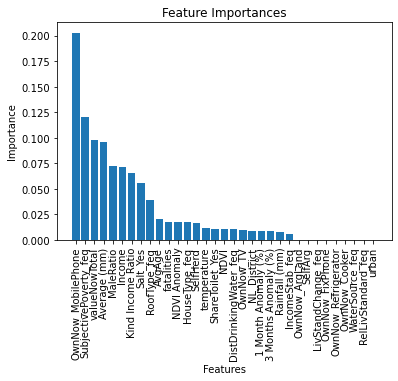

In [188]:
xgb4 = XGBClassifier( learning_rate =0.01, n_estimators=5000, max_depth=2,
 min_child_weight=7, gamma=0.2, subsample=0.6, colsample_bytree=0.7,reg_alpha = 100, 
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
xgb_estimator, test_pred_prob, test_pred_class = modelfit(xgb4, DataTrain, predictorList)

In [189]:
report_train = classification_report(Y_test,test_pred_class,output_dict=True)
pd.DataFrame(report_train).T

,precision,recall,f1-score,support
0,0.765583,0.989492,0.863254,571.000000
1,0.600000,0.049451,0.091371,182.000000
accuracy,0.762284,0.762284,0.762284,0.762284
macro avg,0.682791,0.519471,0.477312,753.000000
weighted avg,0.725561,0.762284,0.676690,753.000000


#### SVM

In [193]:
# X_train = SMOTE_Train['train_9'][predictorList]
# Y_train = SMOTE_Train['train_9']['FCSStaus']
# X_train = ADASYN_Train['train_9'][predictorList]
# Y_train = ADASYN_Train['train_9']['FCSStaus']
X_train = StdTrain['train_9'][predictorList]
Y_train = StdTrain['train_9']['FCSStaus']
# X_train = X_smote
# Y_train = Y_smote
X_test = StdTest['test_9'][predictorList]
Y_test = StdTest['test_9']['FCSStaus']
# Y_test = StdTest['test_9']['FCS']
# X_test = X_smoteT
# Y_test = Y_smoteT

In [195]:
SVMClf = SVC()
grid_svm = {'C':[0.01, 0.1, 1, 10], 'kernel':['linear', 'poly', 'rbf', 'sigmoid']}
cross_svm = GridSearchCV(SVMClf,grid_svm,cv=5,scoring="f1_macro")
cross_svm.fit(X_train, Y_train)

### Case 3: with feature engineering